In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
from jax import grad, jit

from jax import random
key = random.PRNGKey(10)

import scipy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
global theta, tot_origin_flow, transit_cost, ttff_1, ttff_2, cap_1, cap_2, bpr_alpha, bpr_beta

theta = 0.1
tot_origin_flow = 7000
transit_cost = 50.0
ttff_1 = 20
ttff_2 = 30
cap_1  = 4000
cap_2  = 3000
bpr_alpha = 0.15
bpr_beta = 4

In [3]:
@jit
def demand_comp(access_cost, x_paths, lambda_list):

    auto_probs = (jnp.exp(-theta*access_cost)/(jnp.exp(-theta*access_cost)+jnp.exp(-theta*transit_cost)))

    # Link function parameters
    
    tot_vol = tot_origin_flow*auto_probs
    
    # Link travel time function (BPR)
    t_1 = ttff_1*(1 + bpr_alpha*(x_paths/cap_1)**bpr_beta)
    t_2 = ttff_2*(1 + bpr_alpha*((tot_vol - x_paths)/cap_2)**bpr_beta)

    # Path flow travel time
    t_p1 = t_1
    t_p2 = t_2

    # compute min of travel time
    c_s =  jnp.min(jnp.array([t_p1, t_p2]))

    # Time
    cost_demand = access_cost
    path_t = jnp.stack([t_p1, t_p2], 0) 
    
    # Constraints to penalize the costs
    link_condi = access_cost - c_s # integrate demand and supply (c_d - c_s)
    flow_condi = tot_vol - x_paths # flow constraint
    
    ested_val = [x_paths, 
                 path_t, 
                 c_s, 
                 link_condi, 
                 flow_condi]
    
    loss = x_paths*(path_t[0] - c_s) + (tot_vol - x_paths)*(path_t[1] - c_s) \
    + lambda_list[0]*link_condi + (rho_/2)*link_condi**2 + lambda_list[1]*flow_condi + (rho_/2)*flow_condi**2\
    + lambda_list[2]*jax.nn.relu(-x_paths) + (rho_/2)*(jax.nn.relu(-x_paths))**2

    return loss[0]

@jit
def supply_comp(x_paths, access_cost, lambda_list):

    auto_probs = (jnp.exp(-theta*access_cost)/(jnp.exp(-theta*access_cost)+jnp.exp(-theta*transit_cost)))
    
    tot_vol = tot_origin_flow*auto_probs

    # Link travel time function (BPR)
    t_1 = ttff_1*(1 + bpr_alpha*(x_paths/cap_1)**bpr_beta)
    t_2 = ttff_2*(1 + bpr_alpha*((tot_vol - x_paths)/cap_2)**bpr_beta)

    # Path flow travel time
    t_p1 = t_1
    t_p2 = t_2

    # compute min of travel time
    c_s =  jnp.min(jnp.array([t_p1, t_p2]))

    # # Time
    cost_demand = access_cost
    path_t = jnp.stack([t_p1, t_p2], 0) 
    
    # Constraints to penalize the costs
    link_condi = access_cost - c_s # integrate demand and supply (c_d - c_s)
    flow_condi = tot_vol - x_paths # flow constraint
    
    ested_val = [x_paths, 
                 path_t, 
                 c_s, 
                 link_condi, 
                 flow_condi]
    
    loss = x_paths*(path_t[0] - c_s) + (tot_vol - x_paths)*(path_t[1] - c_s) \
    + lambda_list[0]*link_condi + (rho_/2)*link_condi**2 + lambda_list[1]*flow_condi + (rho_/2)*flow_condi**2\
    + lambda_list[2]*jax.nn.relu(-x_paths) + (rho_/2)*(jax.nn.relu(-x_paths))**2

    return loss[0]

@jit
def lambda_condi(up_access_cost, up_x_paths, lambda_list):

    auto_probs = (jnp.exp(-theta*up_access_cost)/(jnp.exp(-theta*up_access_cost)+jnp.exp(-theta*transit_cost)))
    
    # Volume
    tot_vol = tot_origin_flow*auto_probs

    # Link travel time function (BPR)
    t_1 = ttff_1*(1 + bpr_alpha*(up_x_paths/cap_1)**bpr_beta)
    t_2 = ttff_2*(1 + bpr_alpha*((tot_vol - up_x_paths)/cap_2)**bpr_beta)

    # Path flow travel time
    t_p1 = t_1
    t_p2 = t_2

    # compute min of travel time
    c_s =  jnp.min(jnp.array([t_p1, t_p2]))
    
    # # Time
    cost_demand = up_access_cost
    path_t = jnp.stack([t_p1, t_p2], 0) 

    # Constraints to penalize the costs
    link_condi = up_access_cost - c_s # integrate demand and supply (c_d - c_s)
    flow_condi = tot_vol - up_x_paths # flow constraint
    
    lambda_list1 = lambda_list[0] + rho_ * link_condi
    lambda_list2 = lambda_list[1] + rho_ * flow_condi   
    lambda_list3 = lambda_list[2] + rho_*(jax.nn.relu(-up_x_paths))
    
    lambda_list = [lambda_list1, lambda_list2, lambda_list3]
    
    return lambda_list, link_condi

In [4]:
"""TO DO: Formulate the convergence check function and replace 'for' loop to 'while' """
# Initialize the accessibility cost and the path flows
# Variables to be optimized (initial settings)

# Initialize Lagrange multipliers
lambda_1 = 0.0
lambda_2 = 0.0
lambda_3 = 0.0
rho_ = 0.01
lambda_list = jnp.array([lambda_1, lambda_2, lambda_3])

c_d = 46.0
x_path1 = 5333.0

access_cost = jnp.array([c_d])
x_paths  = jnp.array([x_path1])
cost_gap = []
link_gap = []
for i in range(200):
    '''
    Loop over the augmented lagrangian relaxation using the ADMM algorithm
    
    1. Update the accessibility cost
    2. Update the path flows 
    3. Update the lagrangian multipliers
    
    '''
    # Optimization to train the demand component # compute c_d(k+1) fixing x(k)
    train_demand = scipy.optimize.minimize(demand_comp, 
                                             access_cost, 
                                             jac  = jit(jax.grad(demand_comp)),
                                             args = (x_paths, lambda_list),
                                             method='BFGS')
    updated_cost = jnp.array(train_demand.x)

    # set up the shape of the variable    
    # Optimization to train the supply component
    train_supply = scipy.optimize.minimize(supply_comp, 
                                             x_paths, 
                                             jac  = jit(jax.grad(supply_comp)),
                                             args = (updated_cost, lambda_list),
                                             method='BFGS')

    updated_paths = train_supply.x
    updated_lambdas = lambda_condi(updated_cost, updated_paths, lambda_list)[0]

    # Reassign the updated parameters and variables including the lagrangian multipliers
    lambda_list = updated_lambdas
    access_cost = updated_cost
    x_paths = updated_paths
    
    # Print out the sequentially updated results
    print('iteration_step:', i)
    print('1. Updating the generalized travel costs:', access_cost)
    print('2. Updating the optimal path flows:', x_paths)
    print('3. Updating the lambda multiplier for the cost linkage:', lambda_list[0])
    print('4. Updating the lambda multiplier for the flow balance:', lambda_list[1])
    print('5. Updating the lambda multiplier for the flow positivity:', lambda_list[2]) 
    print('6. Check the difference of c_d and c_s:', lambda_condi(access_cost, x_paths, lambda_list)[1])
    print('7. The gap check:', demand_comp(access_cost, x_paths, lambda_list))
    link_gap.append(lambda_condi(access_cost, x_paths, lambda_list)[1])
    cost_gap.append(demand_comp(access_cost, x_paths, lambda_list))
    print()
    

iteration_step: 0
1. Updating the generalized travel costs: [38.7764]
2. Updating the optimal path flows: [5317.89073614]
3. Updating the lambda multiplier for the cost linkage: [0.09404258]
4. Updating the lambda multiplier for the flow balance: [-0.3690777]
5. Updating the lambda multiplier for the flow positivity: [0.]
6. Check the difference of c_d and c_s: [9.404259]
7. The gap check: -1.4134569

iteration_step: 1
1. Updating the generalized travel costs: [38.69002]
2. Updating the optimal path flows: [5310.50441149]
3. Updating the lambda multiplier for the cost linkage: [0.18774097]
4. Updating the lambda multiplier for the flow balance: [-0.55251235]
5. Updating the lambda multiplier for the flow positivity: [0.]
6. Check the difference of c_d and c_s: [9.369839]
7. The gap check: 1.545274

iteration_step: 2
1. Updating the generalized travel costs: [38.644806]
2. Updating the optimal path flows: [5307.02875392]
3. Updating the lambda multiplier for the cost linkage: [0.2812309

iteration_step: 21
1. Updating the generalized travel costs: [38.380596]
2. Updating the optimal path flows: [5330.18921474]
3. Updating the lambda multiplier for the cost linkage: [2.0232227]
4. Updating the lambda multiplier for the flow balance: [-0.56661594]
5. Updating the lambda multiplier for the flow positivity: [0.]
6. Check the difference of c_d and c_s: [8.921448]
7. The gap check: 18.419556

iteration_step: 22
1. Updating the generalized travel costs: [38.359848]
2. Updating the optimal path flows: [5332.74296103]
3. Updating the lambda multiplier for the cost linkage: [2.1120484]
4. Updating the lambda multiplier for the flow balance: [-0.5497442]
5. Updating the lambda multiplier for the flow positivity: [0.]
6. Check the difference of c_d and c_s: [8.882559]
7. The gap check: 19.123516

iteration_step: 23
1. Updating the generalized travel costs: [38.338158]
2. Updating the optimal path flows: [5335.40984998]
3. Updating the lambda multiplier for the cost linkage: [2.200

iteration_step: 42
1. Updating the generalized travel costs: [37.744175]
2. Updating the optimal path flows: [5404.60497231]
3. Updating the lambda multiplier for the cost linkage: [3.7792916]
4. Updating the lambda multiplier for the flow balance: [0.00163175]
5. Updating the lambda multiplier for the flow positivity: [0.]
6. Check the difference of c_d and c_s: [7.7456207]
7. The gap check: 29.818413

iteration_step: 43
1. Updating the generalized travel costs: [37.775734]
2. Updating the optimal path flows: [5404.60497231]
3. Updating the lambda multiplier for the cost linkage: [3.8570635]
4. Updating the lambda multiplier for the flow balance: [0.02990453]
5. Updating the lambda multiplier for the flow positivity: [0.]
6. Check the difference of c_d and c_s: [7.7771797]
7. The gap check: 30.428102

iteration_step: 44
1. Updating the generalized travel costs: [37.798214]
2. Updating the optimal path flows: [5404.60497231]
3. Updating the lambda multiplier for the cost linkage: [3.93

iteration_step: 63
1. Updating the generalized travel costs: [37.79819]
2. Updating the optimal path flows: [5404.60497231]
3. Updating the lambda multiplier for the cost linkage: [5.4169893]
4. Updating the lambda multiplier for the flow balance: [0.04231004]
5. Updating the lambda multiplier for the flow positivity: [0.]
6. Check the difference of c_d and c_s: [7.799637]
7. The gap check: 42.55747

iteration_step: 64
1. Updating the generalized travel costs: [37.79819]
2. Updating the optimal path flows: [5404.60497231]
3. Updating the lambda multiplier for the cost linkage: [5.4949856]
4. Updating the lambda multiplier for the flow balance: [0.04293282]
5. Updating the lambda multiplier for the flow positivity: [0.]
6. Check the difference of c_d and c_s: [7.799637]
7. The gap check: 43.165848

iteration_step: 65
1. Updating the generalized travel costs: [37.79819]
2. Updating the optimal path flows: [5404.60497231]
3. Updating the lambda multiplier for the cost linkage: [5.572982]


iteration_step: 84
1. Updating the generalized travel costs: [37.79835]
2. Updating the optimal path flows: [5404.60497231]
3. Updating the lambda multiplier for the cost linkage: [7.054911]
4. Updating the lambda multiplier for the flow balance: [0.05583066]
5. Updating the lambda multiplier for the flow positivity: [0.]
6. Check the difference of c_d and c_s: [7.799797]
7. The gap check: 55.333508

iteration_step: 85
1. Updating the generalized travel costs: [37.79819]
2. Updating the optimal path flows: [5404.60497231]
3. Updating the lambda multiplier for the cost linkage: [7.1329074]
4. Updating the lambda multiplier for the flow balance: [0.05645344]
5. Updating the lambda multiplier for the flow positivity: [0.]
6. Check the difference of c_d and c_s: [7.799637]
7. The gap check: 55.941887

iteration_step: 86
1. Updating the generalized travel costs: [37.79819]
2. Updating the optimal path flows: [5404.60497231]
3. Updating the lambda multiplier for the cost linkage: [7.2109036]

iteration_step: 105
1. Updating the generalized travel costs: [37.79819]
2. Updating the optimal path flows: [5404.60497231]
3. Updating the lambda multiplier for the cost linkage: [8.692833]
4. Updating the lambda multiplier for the flow balance: [0.06890903]
5. Updating the lambda multiplier for the flow positivity: [0.]
6. Check the difference of c_d and c_s: [7.799637]
7. The gap check: 68.10951

iteration_step: 106
1. Updating the generalized travel costs: [37.79819]
2. Updating the optimal path flows: [5404.60497231]
3. Updating the lambda multiplier for the cost linkage: [8.770829]
4. Updating the lambda multiplier for the flow balance: [0.06953181]
5. Updating the lambda multiplier for the flow positivity: [0.]
6. Check the difference of c_d and c_s: [7.799637]
7. The gap check: 68.717896

iteration_step: 107
1. Updating the generalized travel costs: [37.79819]
2. Updating the optimal path flows: [5404.60497231]
3. Updating the lambda multiplier for the cost linkage: [8.848825]

iteration_step: 126
1. Updating the generalized travel costs: [37.797886]
2. Updating the optimal path flows: [5404.60497231]
3. Updating the lambda multiplier for the cost linkage: [10.330749]
4. Updating the lambda multiplier for the flow balance: [0.08278847]
5. Updating the lambda multiplier for the flow positivity: [0.]
6. Check the difference of c_d and c_s: [7.7993317]
7. The gap check: 80.885544

iteration_step: 127
1. Updating the generalized travel costs: [37.798477]
2. Updating the optimal path flows: [5404.60497231]
3. Updating the lambda multiplier for the cost linkage: [10.408748]
4. Updating the lambda multiplier for the flow balance: [0.08306078]
5. Updating the lambda multiplier for the flow positivity: [0.]
6. Check the difference of c_d and c_s: [7.799923]
7. The gap check: 81.49392

iteration_step: 128
1. Updating the generalized travel costs: [37.798477]
2. Updating the optimal path flows: [5404.60497231]
3. Updating the lambda multiplier for the cost linkage: [10.

iteration_step: 147
1. Updating the generalized travel costs: [37.79819]
2. Updating the optimal path flows: [5404.60497231]
3. Updating the lambda multiplier for the cost linkage: [11.968673]
4. Updating the lambda multiplier for the flow balance: [0.09564153]
5. Updating the lambda multiplier for the flow positivity: [0.]
6. Check the difference of c_d and c_s: [7.799637]
7. The gap check: 93.661545

iteration_step: 148
1. Updating the generalized travel costs: [37.79819]
2. Updating the optimal path flows: [5404.60497231]
3. Updating the lambda multiplier for the cost linkage: [12.046669]
4. Updating the lambda multiplier for the flow balance: [0.09626431]
5. Updating the lambda multiplier for the flow positivity: [0.]
6. Check the difference of c_d and c_s: [7.799637]
7. The gap check: 94.26992

iteration_step: 149
1. Updating the generalized travel costs: [37.79819]
2. Updating the optimal path flows: [5404.60497231]
3. Updating the lambda multiplier for the cost linkage: [12.1246

iteration_step: 168
1. Updating the generalized travel costs: [37.79819]
2. Updating the optimal path flows: [5404.60497231]
3. Updating the lambda multiplier for the cost linkage: [13.606594]
4. Updating the lambda multiplier for the flow balance: [0.10871989]
5. Updating the lambda multiplier for the flow positivity: [0.]
6. Check the difference of c_d and c_s: [7.799637]
7. The gap check: 106.43754

iteration_step: 169
1. Updating the generalized travel costs: [37.79819]
2. Updating the optimal path flows: [5404.60497231]
3. Updating the lambda multiplier for the cost linkage: [13.68459]
4. Updating the lambda multiplier for the flow balance: [0.10934267]
5. Updating the lambda multiplier for the flow positivity: [0.]
6. Check the difference of c_d and c_s: [7.799637]
7. The gap check: 107.04593

iteration_step: 170
1. Updating the generalized travel costs: [37.79819]
2. Updating the optimal path flows: [5404.60497231]
3. Updating the lambda multiplier for the cost linkage: [13.7625

iteration_step: 189
1. Updating the generalized travel costs: [37.79819]
2. Updating the optimal path flows: [5404.60497231]
3. Updating the lambda multiplier for the cost linkage: [15.244513]
4. Updating the lambda multiplier for the flow balance: [0.12219463]
5. Updating the lambda multiplier for the flow positivity: [0.]
6. Check the difference of c_d and c_s: [7.799637]
7. The gap check: 119.21355

iteration_step: 190
1. Updating the generalized travel costs: [37.79819]
2. Updating the optimal path flows: [5404.60497231]
3. Updating the lambda multiplier for the cost linkage: [15.322509]
4. Updating the lambda multiplier for the flow balance: [0.1228174]
5. Updating the lambda multiplier for the flow positivity: [0.]
6. Check the difference of c_d and c_s: [7.799637]
7. The gap check: 119.82194

iteration_step: 191
1. Updating the generalized travel costs: [37.79819]
2. Updating the optimal path flows: [5404.60497231]
3. Updating the lambda multiplier for the cost linkage: [15.4005

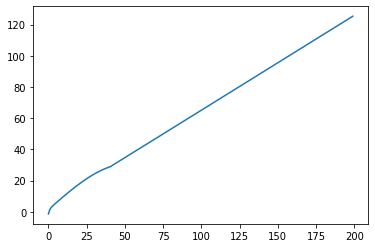

In [5]:
# Loss Function Gap
plt.plot(cost_gap)

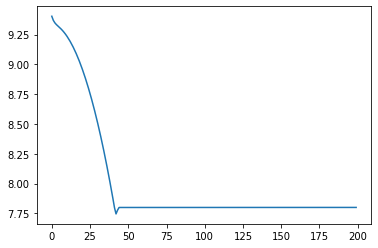

In [6]:
# Linkage Constraint Gap (c_d - c_s)
plt.plot(link_gap)